In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from src.settings import *
import pickle as pkl
import gzip
from src.tools.vis_utils import VisualizationConfig, FIGSIZE, visualize_dendrogram, plot_hexagons_map, plot_clusters
from src.tools.dim_reduction import reduce_umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd
import dataclasses
import json5 as json
from scipy.cluster.hierarchy import cut_tree
from src.tools.configs import ExperimentConfig

In [63]:
run_name = "playful-serenity-30"
run_dir = RUNS_DATA_DIR / run_name

with gzip.open(run_dir / "dataset.pkl.gz", "rb") as f:
    ds = pkl.load(f)

z_df = pd.read_pickle(run_dir / "embeddings.pkl.gz")

In [64]:
ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [65]:
z_df

z_0       z_1       z_2  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5106993ffff  0.479923  0.295526 -0.167560   
                            891f5106993ffff  0.399952 -0.265734  0.756131   
                            891f5106d67ffff  0.399952 -0.265734  0.756131   
                            891f5106997ffff  0.490680 -0.024095  0.608531   
                            891f5106993ffff  0.490680 -0.024095  0.608531   
...                                               ...       ...       ...   
                  Łódź      891e2186aafffff  0.002068  0.217183 -0.215378   
                            891e2186a33ffff  0.002068  0.217183 -0.215378   
                            891e2186a33ffff  0.002068  0.217183 -0.215378   
                            891e2186a33ffff  0.002068  0.217183 -0.215378   
                            891e2186aafffff  0.002068  0.217183 -0.215378   

                                                  z_3       z_4       z_5  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5106993ffff -0.560749  0.382325  0.045831   
                            891f5106993ffff  0.295894  0.501590  0.196160   
                            891f5106d67ffff  0.295894  0.501590  0.196160   
                            891f5106997ffff  0.224963  0.459282  0.422117   
                            891f5106993ffff  0.224963  0.459282  0.422117   
...                                               ...       ...       ...   
                  Łódź      891e2186aafffff  0.117646  0.037693 -0.230708   
                            891e2186a33ffff  0.117646  0.037693 -0.230708   
                            891e2186a33ffff  0.117646  0.037693 -0.230708   
                            891e2186a33ffff  0.117646  0.037693 -0.230708   
                            891e2186aafffff  0.117646  0.037693 -0.230708   

                                                  z_6       z_7       z_8  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5106993ffff  0.286910  0.460893  0.275466   
                            891f5106993ffff  0.442064  0.247089  0.168095   
                            891f5106d67ffff  0.442064  0.247089  0.168095   
                            891f5106997ffff  0.228262 -0.003705  0.278777   
                            891f5106993ffff  0.228262 -0.003705  0.278777   
...                                               ...       ...       ...   
                  Łódź      891e2186aafffff  0.018707 -0.002742  0.227727   
                            891e2186a33ffff  0.018707 -0.002742  0.227727   
                            891e2186a33ffff  0.018707 -0.002742  0.227727   
                            891e2186a33ffff  0.018707 -0.002742  0.227727   
                            891e2186aafffff  0.018707 -0.002742  0.227727   

                                                  z_9  ...      z_20  \
continent country city      h3_id                      ...             
Europe    Poland  Białystok 891f5106993ffff -0.482686  ...  0.002434   
                            891f5106993ffff  0.049875  ... -0.272809   
                            891f5106d67ffff  0.049875  ... -0.272809   
                            891f5106997ffff -0.146689  ... -0.044459   
                            891f5106993ffff -0.146689  ... -0.044459   
...                                               ...  ...       ...   
                  Łódź      891e2186aafffff  0.200719  ...  0.271329   
                            891e2186a33ffff  0.200719  ...  0.271329   
                            891e2186a33ffff  0.200719  ...  0.271329   
                            891e2186a33ffff  0.200719  ...  0.271329   
                            891e2186aafffff  0.200719  ...  0.271329   

                                                 z_21      z_22      z_23  \
continent country city      h3

In [66]:
with open(run_dir / "experiment_config.json", "r") as f:
    ec_json = json.load(f)
    ec = ExperimentConfig(**ec_json)
ec

ExperimentConfig(dataset_filename='dataset_2021-11-29_20-45-47.pkl.gz', model_name='autoencoder', mode='edges', test_cities=['Łódź'], random_seed=42, batch_size=64, num_workers=3, shuffle=True, hidden_dim=64, enc_out_dim=40, latent_dim=30, epochs=10, kl_coeff=0.1, lr=0.001)

In [67]:
if ec.mode == "edges":
    z_df = z_df.groupby(level=[0, 1, 2, 3]).mean()

In [68]:
# TODO: reinit wandb project

In [70]:
vc = VisualizationConfig(
    n_clusters=None,
    distance_threshold=0,
    affinity="euclidean",
    linkage="ward",
    truncate_mode="level",
    p=5,
    clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    cities_to_plot=["Wrocław", "Bydgoszcz", "Trójmiasto", "Warszawa"],
    umap_n_components=2,
    umap_n_neighbours=30,
    umap_metric="euclidean",
)

vis_dir = run_dir / "vis"
vis_dir.mkdir(parents=True, exist_ok=True)

with open(vis_dir / "vis_config.json", "w") as f:
    json.dump(dataclasses.asdict(vc), f, indent=2, quote_keys=True, trailing_commas=False)

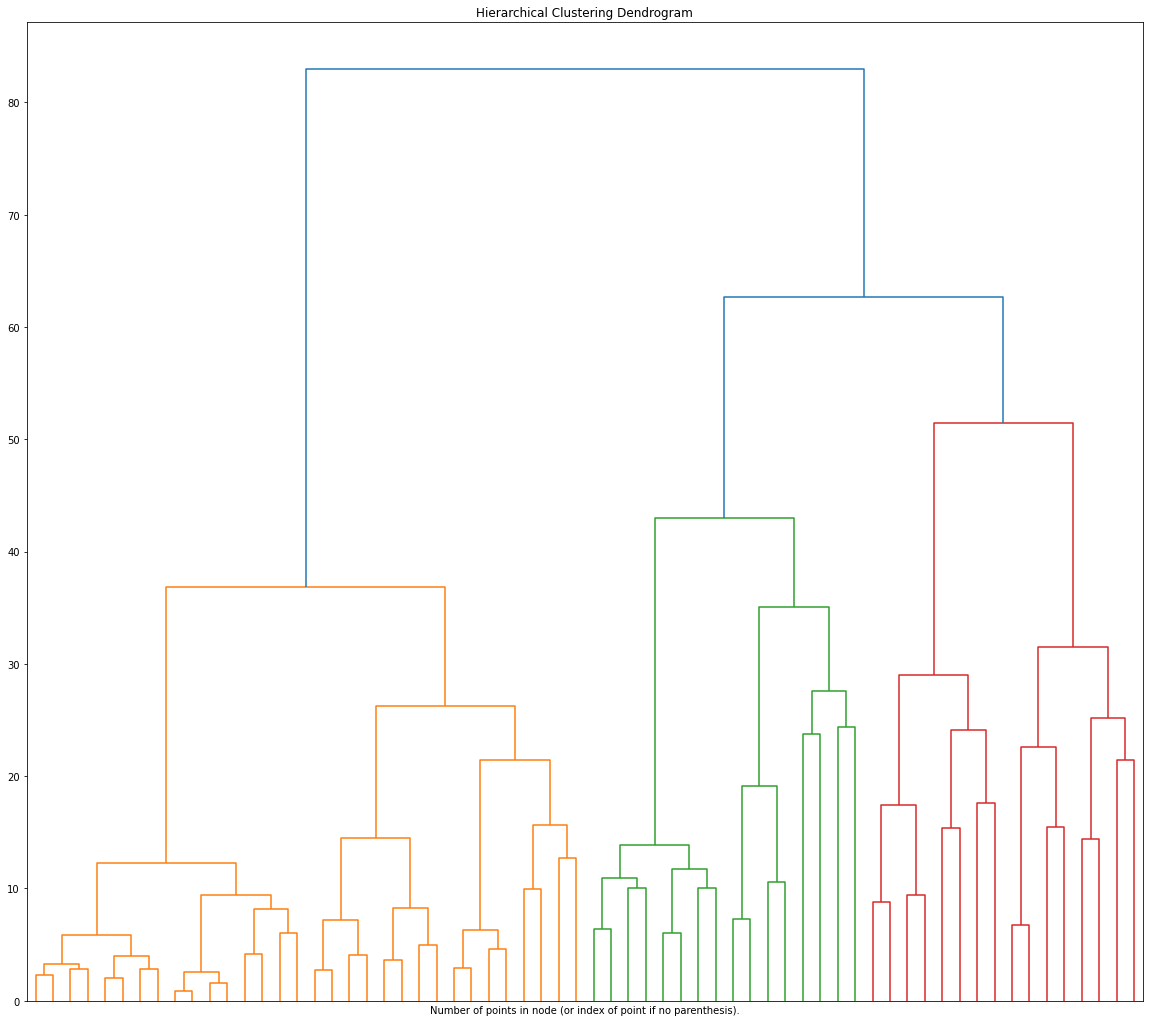

In [71]:

dendrogram_path = vis_dir / "dendrogram.png"

ac_model = AgglomerativeClustering(n_clusters=vc.n_clusters, distance_threshold=vc.distance_threshold, affinity=vc.affinity, linkage=vc.linkage)
ac_model.fit(z_df)
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

linkage_matrix = visualize_dendrogram(ac_model, truncate_mode=vc.truncate_mode, p=vc.p, ax=ax, no_labels=True)

fig.savefig(dendrogram_path)
plt.show()

In [72]:
hexagons = ds.hexagons
z_df_with_clusters = z_df.copy()
cut_tree_results = cut_tree(linkage_matrix, n_clusters = vc.clusters)

for index, c in enumerate(vc.clusters):
    assigned_clusters = cut_tree_results[:, index]
    z_df_with_clusters[f"cluster_{c}"] = pd.Series(assigned_clusters, index=z_df.index).astype("category")

hexagons_clustered = hexagons.join(z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]).dropna().set_crs(epsg=4326)
hexagons_clustered.head(3)


coordinates  \
continent country city      h3_id                                                      
Europe    Poland  Białystok 891f51335a7ffff  (53.13378428677438, 23.198834404101717)   
                            891f51a9b6fffff  (53.13685044196499, 23.170395246099147)   
                            891f5106997ffff  (53.14056625128815, 23.110736734534687)   

                                                      parent  \
continent country city      h3_id                              
Europe    Poland  Białystok 891f51335a7ffff  881f51335bfffff   
                            891f51a9b6fffff  881f51a9b7fffff   
                            891f5106997ffff  881f510699fffff   

                                                                                      children  \
continent country city      h3_id                                                                
Europe    Poland  Białystok 891f51335a7ffff  {'8a1f51335a67fff', '8a1f51335a57fff', '8a1f51...   
                            891f51a9b6fffff  {'8a1f51a9b6effff', '8a1f51a9b6cffff', '8a1f51...   
                            891f5106997ffff  {'8a1f51069947fff', '8a1f5106995ffff', '8a1f51...   

                                             resolution  \
continent country city      h3_id                         
Europe    Poland  Białystok 891f51335a7ffff           9   
                            891f51a9b6fffff           9   
                            891f5106997ffff           9   

                                                                                      geometry  \
continent country city      h3_id                                                                
Europe    Poland  Białystok 891f51335a7ffff  POLYGON ((23.19629 53.13466, 23.19618 53.13302...   
                            891f51a9b6fffff  POLYGON ((23.16785 53.13772, 23.16774 53.13609...   
                            891f5106997ffff  POLYGON ((23.10819 53.14144, 23.10808 53.13980...   

                                            cluster_2 cluster_3 cluster_4  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f51335a7ffff         0         1         1   
                            891f51a9b6fffff         0         1         1   
                            891f5106997ffff         0         0         0   

                                            cluster_5 cluster_6  ...  \
continent country city      h3_id                                ...   
Europe    Poland  Białystok 891f51335a7ffff         2         2  ...   
                            891f51a9b6fffff         2         2  ...   
                            891f5106997ffff         0         0  ...   

                                            cluster_11 cluster_12 cluster_13  \
continent country city      h3_id                                              
Europe    Poland  Białystok 891f51335a7ffff          3          4          4   
                            891f51a9b6fffff          3          4          4   
                            891f5106997ffff          1          1          1   

                                            cluster_14 cluster_15 cluster_16  \
continent country city      h3_id                                              
Europe    Poland  Białystok 891f51335a7ffff          4          4          4   
                            891f51a9b6fffff          4          4          4   
                            891f5106997ffff          1          1          1   

                                            cluster_17 cluster_18 cluster_19  \
continent country city      h3_id                                              
Europe    Poland  Białystok 891f51335a7ffff          4          5          5   
                            891f51a9b6fffff          4          5          5   
                            891f5106997ffff          1          3          3   

                                            cluster_20  
continent country city    

In [73]:
df_clusters = z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]
df_clusters.to_pickle(vis_dir / "clusters.pkl.gz")

In [87]:
hexagons_dir = vis_dir / "hexagons"
hexagons_dir.mkdir(parents=True, exist_ok=True)
for ctp in vc.cities_to_plot:
    for c in vc.clusters:
        ax = plot_hexagons_map(hexagons_clustered.loc[:, :, ctp], ds.edges.loc[:, :, ctp], f"cluster_{c}")
        plt.savefig(hexagons_dir / f"{ctp}_cluster_{c}.png")
        plt.close()

In [75]:
from src.tools.vis_utils import visualize_kepler
config_name = "clusters"
m = visualize_kepler(ds.hexagons.loc[:, ["geometry"]], config_name=config_name)
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':                                                                                       g…

In [76]:
umap_dir = vis_dir / "umap"
umap_dir.mkdir(parents=True, exist_ok=True)
z_df_umaped = reduce_umap(z_df, n_components=vc.umap_n_components, n_neighbors=vc.umap_n_neighbours, metric=vc.umap_metric)[0]
for c in vc.clusters:
    cluster_to_show = f"cluster_{c}"
    z_df_umaped["cluster"] = z_df_with_clusters[cluster_to_show]
    fig = plot_clusters(z_df_umaped)
    fig.write_image(umap_dir / f"umap_{c}.png")

In [77]:
hex_id_aow = "891e20423afffff"
hex_id_high_rank = "891e204284fffff"


In [78]:
hex_aow = z_df.reset_index(level=[0, 1, 2], drop=True).loc[hex_id_aow, :].values
hex_high_rank = z_df.reset_index(level=[0, 1, 2], drop=True).loc[hex_id_high_rank, :].values
hex_diff = hex_aow - hex_high_rank
hex_diff

array([-0.9853854 , -0.22781596,  0.34987146,  0.533077  , -0.3968703 ,
        0.11929999, -0.36054978, -0.03118829,  0.34523907, -0.6768656 ,
       -0.48748016, -0.10696545,  0.34192938,  0.4580999 , -0.44791046,
        0.72094667, -1.4446225 ,  0.6621467 ,  0.94329727, -0.00322634,
        0.98913693,  1.9520127 ,  0.69659424, -1.105996  ,  0.14129198,
        0.34437543, -0.5499329 ,  0.17868039, -0.8021244 ,  1.3711358 ],
      dtype=float32)

In [79]:
z_df_wroc = z_df.reset_index(level=[0, 1], drop=True).loc[["Wrocław"], :]
z_df_wroc

z_0       z_1       z_2       z_3       z_4  \
city    h3_id                                                               
Wrocław 891e2040007ffff -0.114746 -0.020711 -0.052086 -0.094696 -0.028005   
        891e2040013ffff -0.365328  0.197018  0.213779 -0.334018  0.134904   
        891e2040017ffff -0.108117  0.042755  0.009487 -0.022709  0.095572   
        891e2040023ffff -0.097223  0.259388 -0.252548  0.018972 -0.026687   
        891e2040027ffff -0.199927 -0.113206 -0.021424 -0.014112  0.064511   
...                           ...       ...       ...       ...       ...   
        891e2055b6fffff -0.012826  0.223514 -0.220954  0.102845  0.028036   
        891e2055b73ffff  0.002068  0.217183 -0.215378  0.117646  0.037693   
        891e2055b77ffff  0.002068  0.217183 -0.215378  0.117646  0.037693   
        891e2055bc3ffff -0.642646  0.197560  0.343692  0.480139 -0.264646   
        891e2055bcbffff -0.824957  0.211300  0.363841  0.496409 -0.400151   

                              z_5       z_6       z_7       z_8       z_9  \
city    h3_id                                                               
Wrocław 891e2040007ffff -0.062472  0.286301  0.018497 -0.067062  0.059014   
        891e2040013ffff  0.259372 -0.000400  0.031325  0.060770 -0.221163   
        891e2040017ffff  0.019308  0.138430 -0.003680  0.125260  0.039300   
        891e2040023ffff -0.218463 -0.158448  0.295262  0.229757  0.077893   
        891e2040027ffff  0.043157  0.070706  0.137760  0.136751  0.001004   
...                           ...       ...       ...       ...       ...   
        891e2055b6fffff -0.228872 -0.007866  0.041958  0.228032  0.182295   
        891e2055b73ffff -0.230708  0.018707 -0.002742  0.227727  0.200719   
        891e2055b77ffff -0.230708  0.018707 -0.002742  0.227727  0.200719   
        891e2055bc3ffff  0.176370 -0.425562  0.648783 -0.773745  0.221918   
        891e2055bcbffff  0.164217 -0.360765  0.682624 -0.792695  0.144365   

                         ...      z_20      z_21      z_22      z_23  \
city    h3_id            ...                                           
Wrocław 891e2040007ffff  ... -0.103748  0.162511 -0.126433  0.190562   
        891e2040013ffff  ...  0.347765 -0.046508 -0.078622 -0.083850   
        891e2040017ffff  ...  0.177247  0.080276 -0.054737  0.002232   
        891e2040023ffff  ...  0.230120  0.143927  0.254006 -0.098775   
        891e2040027ffff  ...  0.029182  0.230917  0.097599  0.129633   
...                      ...       ...       ...       ...       ...   
        891e2055b6fffff  ...  0.265148  0.207313  0.046613 -0.056925   
        891e2055b73ffff  ...  0.271329  0.218499  0.010014 -0.049540   
        891e2055b77ffff  ...  0.271329  0.218499  0.010014 -0.049540   
        891e2055bc3ffff  ...  0.065891  2.260659  0.368704 -0.588202   
        891e2055bcbffff  ...  0.041115  2.466864  0.346580 -0.620675   

                             z_24      z_25      z_26      z_27      z_28  \
city    h3_id                                                               
Wrocław 891e2040007ffff  0.634313 -0.023939  0.001960 -0.140614  0.064282   
        891e2040013ffff  0.843496 -0.161937  0.102368 -0.124518 -0.329831   
        891e2040017ffff  0.565533  0.117325 -0.019819 -0.130730 -0.059441   
        891e2040023ffff  0.670858 -0.000519  0.003252 -0.207696 -0.121534   
        891e2040027ffff  0.697283  0.164926 -0.045842 -0.069903  0.027611   
...                           ...       ...       ...       ...       ...   
        891e2055b6fffff  0.498166  0.096101 -0.009771 -0.115422 -0.117254   
        891e2055b73ffff  0.467690  0.113152 -0.012070 -0.099139 -0.116499   
        891e2055b77ffff  0.467690  0.113152 -0.012070 -0.099139 -0.116499   
        891e2055bc3ffff  1.483677  0.708922 -0.128908  0.080536  0.289154   
        891e2055bcbffff  1.539602  0.715362 -0.136850  0.100089  0.250805   

                             z_29  
city    h3_id                      
Wrocław 891e204

In [80]:
import numpy as np

dist = np.linalg.norm(z_df_wroc.values - hex_diff, axis=1)
dist.argmin()

1033

In [81]:
z_df_wroc.iloc[1033].name

('Wrocław', '891e2042c0bffff')

In [82]:
# TODO: https://towardsdatascience.com/interpretable-k-means-clusters-feature-importances-7e516eeb8d3c
# and szymon

In [83]:
# hexagons_clustered_agg = hex_agg
# hexagons_clustered_agg["cluster_10"] = hexagons_clustered["cluster_10"]
# hexagons_clustered_agg

In [84]:
# hex_tfidf_by_cluster_mean = hex_tfidf_by_cluster.mean().reset_index()
# hex_tfidf_by_cluster_mean

In [85]:
# import plotly.graph_objects as go

# features_selected = featureset_selection_config["features"]
# fig = go.Figure()
# for feature_name in features_selected.keys():
#     # print(feature_name)
#     feature_group = list(filter(lambda x: feature_name in x, hexagons_clustered_agg.columns))
#     for feature in feature_group:
#         fig.add_trace(go.Box(
#             x=hexagons_clustered_agg['cluster_10'],
#             y=hexagons_clustered_agg[feature],
#             name=feature
#         ))

#     # fig = px.box(hexagons_clustered_agg, boxmode="group", x="cluster_10", y=feature_group, width=1300, title=feature_name)
#     fig.update_layout(
#         xaxis = dict(
#             tickmode = 'linear',
#         ),
#         boxmode='group'
#     )
#     fig.show()

In [86]:
# features_selected = featureset_selection_config["features"]
# for feature_name in features_selected.keys():
#     # print(feature_name)
#     feature_group = list(filter(lambda x: feature_name in x, hexagons_clustered_agg.columns))
#     fig = px.bar(hexagons_clustered_agg, x="cluster_10", y=feature_group, width=1300, title=feature_name)
#     fig.update_layout(
#         xaxis = dict(
#             tickmode = 'linear',
#         )
#     )
#     fig.show()